# Walkthrough - RBIG

In [1]:
import sys
sys.path.append("../")

# jax packages
import jax
import jax.numpy as np
from jax.config import config
import chex
config.update("jax_enable_x64", True)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.information.rbig import rbig_init
from rbig_jax.information.reduction import information_reduction
from rbig_jax.information.entropy import histogram_entropy
from rbig_jax.plots.info import plot_total_corr
from rbig_jax.plots.joint import plot_joint
from rbig_jax.plots.prob import plot_joint_prob
from rbig_jax.transforms.gaussian import init_params

# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

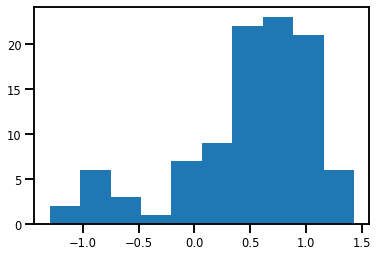

In [2]:
# get data
data = get_classic(100)

# plot data
plt.hist(data[:, 1], 10);

## Logging

In [3]:
wandb.init(project="rbigjax-demo-2d", entity="emanjohnson91")


W&B Run: https://app.wandb.ai/emanjohnson91/rbigjax-demo-2d/runs/1dw74b7y

In [4]:

# config parameters
wandb.config.n_samples = 10_000
wandb.config.dataset = "classic"
wandb.config.method = "histogram"
wandb.config.support_extension = 10
wandb.config.precision = 50
wandb.config.alpha = 0.0
wandb.config.n_layers = 20

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


## Data

In [5]:
def plot_joint(data, color: str = "red", title: str = "", kind="kde", logger=None):

    plt.figure()
    sns.jointplot(x=data[:, 0], y=data[:, 1], kind=kind, color=color)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    

def plot_joint_prob(data, probs, cmap="Reds", title="", logger=None):

    fig, ax = plt.subplots()
    h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs, cmap=cmap)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.colorbar(h,)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

<Figure size 432x288 with 0 Axes>

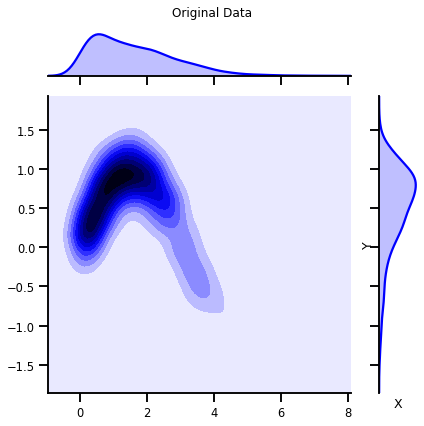

In [6]:
# %%wandb
# get data
data = get_classic(1_000)

# plot data
plot_joint(data, "blue", "Original Data", logger=False)

## Initialization

First we need to initialize our RBIG method with some parameters. For example, which marginal gaussianization method, what precision do we want, and what rotation method do we want.

* `method` - the method used to marginally transform the data. We have histogram or kde currently implemented
* `support_extension` - this is the amount we want to extend the support for our marginal distributions. Higher values indicate higher
* `precision` - we use interpolation because it is much faster. So the CDF, PDF and PPF are interpolation schemes. This value will allow one to have more "precision" for the estimated quantities but it will be slower.

In [7]:


# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=50,
    alpha=1e-5
)

In [8]:
# fit forward function
Xtrans = fit_forward_func(data)

chex.assert_shape(Xtrans, (1_000, 2))

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


<Figure size 432x288 with 0 Axes>

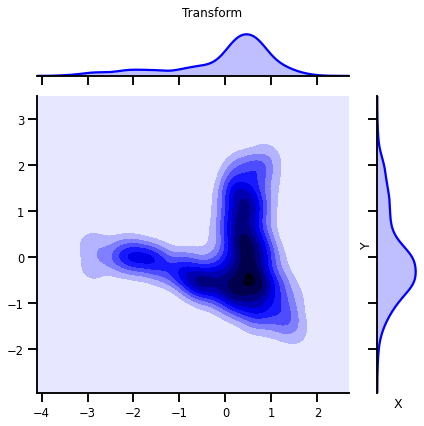

In [9]:
plot_joint(Xtrans, "blue", "Transform", logger=False)

### Speed

We can use the `jit` method to speed up our code considerably. We simply need to jit our forward function and our inverse function.

#### Non-Jitted

In [10]:
%timeit Xtrans = fit_forward_func(data)

226 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


#### Jitted

In [11]:
# get the init function
fit_forward_func = rbig_init(
    method="histogram",
    support_ext=10,
    precision=100,
    alpha=1e-5
)
fit_forward_func_jitted = jax.jit(fit_forward_func)
Xtrans = fit_forward_func_jitted(data)

In [12]:
%timeit _ = fit_forward_func_jitted(data)

678 µs ± 212 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Training

So now we have our step function and we need some kinda of condition. We will do 3 conditions:

1. We need a maximum number of layers
2. We need a minimum number of layers
3. We need no changes between a running loss

In [14]:
from collections import namedtuple

data = get_classic(10_000)
# data = np.array(onp.random.randn(10_000, 100))

max_layers = 100
min_layers = 10
threshold = 0.25
tol_layers = 50

TrainState = namedtuple(
    "TrainState", [
        "n_layers", # number of layers 
        "info_loss", # information loss
        "X",
    ]
)

train_state = TrainState(
    n_layers=0,
    info_loss=np.zeros((1_000,)),
    X=data,
    
)



@jax.jit
def condition_fun(state):
    # stopping criterial
    stop_crit = jax.lax.bitwise_and(
        jax.lax.bitwise_not(state.n_layers < min_layers), 
        state.n_layers > max_layers
    )
    stop_crit = jax.lax.bitwise_not(stop_crit)
    return stop_crit

condition_fun(train_state)
# train_state = (
#     0, np.zeros((1_000,)), data
    
# )
# information reduction function
it_jitted = jax.jit(information_reduction)

# body function
def body_jitted(train_state):
    Xtrans = fit_forward_func_jitted(train_state.X)

    # calculate the information loss
    it = it_jitted(train_state.X, Xtrans)


    return TrainState(
        train_state.n_layers + 1,
        jax.ops.index_update(train_state.info_loss, train_state.n_layers+1, it),
        Xtrans,
    )



In [15]:
%%time
state = jax.lax.while_loop(condition_fun, body_jitted, train_state)

CPU times: user 9.38 s, sys: 49.7 ms, total: 9.43 s
Wall time: 9.39 s


In [22]:
state

array(101, dtype=int64)

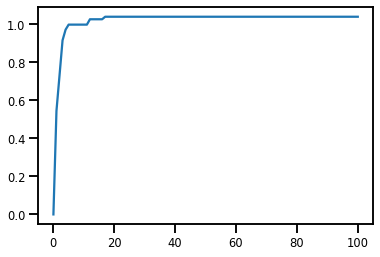

In [23]:
plt.plot(onp.array(np.cumsum(state[1]))[:onp.array(state[0])])

### RBIG 4 IT


In [92]:
from rbig_jax.information.total_corr import rbig_total_corr

In [94]:
state = rbig_total_corr(data, fit_forward_func_jitted)

In [96]:
print(f"Mutual Info: {state.mutual_info:.4f}")
print(f"Entropy: {state.entropy:.4f}")

Mutual Info: 9.9093
Entropy: 18.8546


### Total Correlation

#### Sample Data

In [97]:
from sklearn.utils import check_random_state

#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

# covariance matrix
C = A.T @ A
vv = onp.diag(C)

#### Original 

In [55]:
tc_original = onp.log(onp.sqrt(vv)).sum() - 0.5 * onp.log(onp.linalg.det(C))

print(f"TC: {tc_original:.4f}")

TC: 9.9326


#### RBIG

In [98]:
state = rbig_total_corr(data, fit_forward_func_jitted)

print(f'Total Correlation: {state.mutual_info:.4f}')

Total Correlation: 9.9093


### Entropy

#### Sample Data

In [99]:
#Parameters
n_samples = 10_000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random normal data
data_original = rng.randn(n_samples, d_dimensions)

# Generate random Data
A = rng.rand(d_dimensions, d_dimensions)

data = data_original @ A

#### True Entropy

In [100]:
Hx = jax.vmap(histogram_entropy, in_axes=(0, None))(data.T, 2)

print(f"Hx: {Hx.sum():.4f}")

H_original = Hx.sum() + np.log2(np.abs(np.linalg.det(A)))

# H_original *= np.log(2)

print(f"H: {H_original:.4f}")

Hx: 28.7639
H: 22.7575


### RBIG

In [103]:
%%time
state = rbig_total_corr(data, fit_forward_func_jitted)

print(f'Entropy: {state.entropy:.4f}')

Entropy: 18.8546
CPU times: user 15.9 s, sys: 15.8 s, total: 31.8 s
Wall time: 14.5 s


### Mutual Information

In [112]:
#Parameters
n_samples = 10000
d_dimensions = 10

seed = 123

rng = check_random_state(seed)

# Generate random Data
A = rng.rand(2 * d_dimensions, 2 * d_dimensions)

# Covariance Matrix
C = A @ A.T
mu = np.zeros((2 * d_dimensions))

dat_all = rng.multivariate_normal(mu, C, n_samples)

CX = C[:d_dimensions, :d_dimensions]
CY = C[d_dimensions:, d_dimensions:]

X = dat_all[:, :d_dimensions]
Y = dat_all[:, d_dimensions:]

#### Real Mutual Information

In [113]:
H_X = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CX)))
H_Y = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(CY)))
H = 0.5 * np.log(2 * np.pi * np.exp(1) * np.abs(np.linalg.det(C)))

mi_original = H_X + H_Y - H
mi_original *= np.log(2)

print(f"MI: {mi_original:.4f}")

MI: 8.0713


#### RBIG

In [134]:
from rbig_jax.information.mi import rbig_mutual_info

In [135]:
%%time
state = rbig_mutual_info(np.array(X), np.array(Y), fit_forward_func_jitted)

CPU times: user 56.9 s, sys: 3min 56s, total: 4min 53s
Wall time: 35 s


In [136]:
print(f"Mutual Info, MI(X,Y): {state.mutual_info:.4f}")
print(f"Mutual Info, MI(X): {state.MIx:.4f}")
print(f"Mutual Info, MI(Y): {state.MIy:.4f}")

Mutual Info, MI(X,Y): 7.6302
Mutual Info, MI(X): 6.9740
Mutual Info, MI(Y): 6.4250
